In [1]:
import sys
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from PIL import Image
import torch
import fiona
import geopandas as gpd
from pyproj import Transformer
import rasterio
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
import seaborn as sns

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.realpath(os.path.abspath(""))))

from utils.parallel import paral

In [2]:
labels_dir = "/net/data_ssd/tree_mortality_orthophotos/labels_and_aois/"
cores = 30

In [3]:
meta_df = pd.read_csv("/net/scratch/jmoehring/meta/metadata_manual_with_resolution.csv")

In [4]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles/register.csv")

In [8]:
register_df.iloc[239138]["file_path"]

'/net/scratch/jmoehring/tiles/20211007_FVA_Walddrohnen_Totholz_2_ortho/0.04/11223_11191.tif'

In [5]:
register_df.columns

Index(['base_file_name', 'file_path', 'global_file_path', 'resolution', 'x',
       'y', 'label_quality', 'resolution_bin', 'original', 'biome'],
      dtype='object')

In [6]:
meta_df.columns

Index(['filename', 'project_id', 'authors_image', 'acquisition_date_month',
       'acquisition_date_day', 'acquisition_date_year',
       'acquisition_date_precise', 'email', 'label_type', 'label_source',
       'image_platform', 'image_spectral_properties', 'citation_doi',
       'label_quality', 'has_labels', 'license', 'public',
       'additional_information', 'west', 'east', 'south', 'north', 'width',
       'height', 'crs'],
      dtype='object')

In [7]:
# get distict base images from register and inner join with meta_df filename
base_images_df = (
    register_df.groupby("base_file_name")
    .agg({"resolution": "min", "biome": "first"})
    .reset_index()
)

# also add biome and resolution to the base images as they are always the same for each base image
meta_df = pd.merge(
    meta_df, base_images_df, right_on="base_file_name", left_on="filename", how="inner"
)

In [8]:
def get_aoi_area(filename, meta_df):
    if filename.endswith(".gpkg"):
        image_name = filename.replace("_polygons.gpkg", ".tif")
        if image_name in meta_df["filename"].values:
            filepath = os.path.join(labels_dir, filename)
            layers = fiona.listlayers(filepath)

            if "aoi" in layers:
                gdf_label = gpd.read_file(filepath, layer="aoi")
                gdf_label = gdf_label.to_crs({"proj": "cea"})
                return (image_name, gdf_label.area.sum() / 10**4)

In [9]:
output = paral(
    get_aoi_area,
    [os.listdir(labels_dir), [meta_df] * len(os.listdir(labels_dir))],
    num_cores=cores,
)

get_aoi_area:   0%|          | 0/1175 [00:00<?, ?jobs/s]

get_aoi_area: 100%|██████████| 1175/1175 [00:06<00:00, 193.22jobs/s]


In [10]:
# remove all None values from the output
output = [x for x in output if x is not None]
# convert list of tuples to dataframe
output_df = pd.DataFrame(output, columns=["filename", "aoi_area"])
# merge with meta_df
meta_df = pd.merge(meta_df, output_df, on="filename", how="inner")

In [11]:
meta_df["aoi_area"].sum()

10117.283958370073

In [12]:
meta_df["biome"].value_counts()

biome
4.0     277
12.0     84
5.0      27
6.0      10
1.0       5
13.0      4
10.0      1
2.0       1
Name: count, dtype: int64

In [13]:
# get number of distinct base images
meta_df["base_file_name"].nunique()

409

In [14]:
biome_dict = {
    1: "Tropical and Subtropical Moist Broadleaf Forests",
    2: "Tropical and Subtropical Dry Broadleaf Forests",
    3: "Tropical and Subtropical Coniferous Forests",
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    7: "Tropical and Subtropical Grasslands, Savannas, and Shrublands",
    8: "Temperate Grasslands, Savannas, and Shrublands",
    9: "Flooded Grasslands and Savannas",
    10: "Montane Grasslands and Shrublands",
    11: "Tundra",
    12: "Mediterranean Forests, Woodlands, and Scrub",
    13: "Deserts and Xeric Shrublands",
    14: "Mangroves",
}

In [15]:
# add biome names to the meta_df
meta_df["biome_name"] = meta_df["biome"].map(biome_dict)

In [16]:
# Define a function to transform a point's CRS
def reproject_to_epsg_4326(row):
    original_crs = row["crs"]
    # Create a GeoDataFrame for the point with the specified CRS
    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy([row["centroid_x"]], [row["centroid_y"]]),
        crs=original_crs,
    )
    # Transform to EPSG:4326
    gdf = gdf.to_crs("EPSG:4326")
    # Return the transformed coordinates
    return gdf.geometry.x[0], gdf.geometry.y[0]

In [17]:
# add EPSG:4326 centroid to metadata caluclated from the bounding box and the projection
meta_df["centroid_x"] = meta_df.apply(lambda x: (x["west"] + x["east"]) / 2, axis=1)
meta_df["centroid_y"] = meta_df.apply(lambda x: (x["south"] + x["north"]) / 2, axis=1)

meta_df[["centroid_x_4326", "centroid_y_4326"]] = meta_df.apply(
    reproject_to_epsg_4326, axis=1, result_type="expand"
)

In [18]:
# convert the metadata to a geodataframe with POINT geometry
meta_gdf = gpd.GeoDataFrame(
    meta_df,
    geometry=gpd.points_from_xy(meta_df["centroid_x_4326"], meta_df["centroid_y_4326"]),
    crs="EPSG:4326",
)

In [19]:
# save the metadata to a geopackage
meta_gdf.to_file("/net/scratch/jmoehring/meta/metadata.gpkg", driver="GPKG")

In [20]:
# group by biome name and sum aoi area, weighted mean of the resolutions by the area aoi, and count of the files
biome_df = (
    meta_df.groupby("biome_name")
    .agg(
        {
            "aoi_area": "sum",
            "resolution": "mean",
            "filename": "count",
        }
    )
    .reset_index()
)

# round aoi area to 2 decimal places
biome_df["aoi_area"] = biome_df["aoi_area"].round(2)

# take resolution by 100 and round to 2 decimal places
biome_df["resolution"] = (biome_df["resolution"] * 100).round(2)

In [24]:
# order biome df by aoi area
biome_df = biome_df.sort_values("aoi_area", ascending=False)

In [26]:
biome_df["aoi_area"].sum()

10117.279999999999

In [27]:
biome_df["filename"].sum()

409

In [25]:
biome_df.to_csv("/net/scratch/jmoehring/meta/biome_stats.csv", index=False, sep=";")

In [22]:
biome_df.head()

,biome_name,aoi_area,resolution,filename
0,Boreal Forests/Taiga,92.90,3.36,10
1,Deserts and Xeric Shrublands,4.00,0.92,4
2,"Mediterranean Forests, Woodlands, and Scrub",4624.62,21.04,84
3,Montane Grasslands and Shrublands,1.00,1.10,1
4,Temperate Broadleaf and Mixed Forests,4252.66,2.92,277


In [23]:
meta_df.columns

Index(['filename', 'project_id', 'authors_image', 'acquisition_date_month',
       'acquisition_date_day', 'acquisition_date_year',
       'acquisition_date_precise', 'email', 'label_type', 'label_source',
       'image_platform', 'image_spectral_properties', 'citation_doi',
       'label_quality', 'has_labels', 'license', 'public',
       'additional_information', 'west', 'east', 'south', 'north', 'width',
       'height', 'crs', 'base_file_name', 'resolution', 'biome', 'aoi_area',
       'biome_name', 'centroid_x', 'centroid_y', 'centroid_x_4326',
       'centroid_y_4326'],
      dtype='object')

In [15]:
meta_df.to_csv("/net/scratch/jmoehring/meta/ortho_metadata_annot.csv", index=False)

In [ ]:
# convert meta_df to geodataframe
meta_gdf = gpd.GeoDataFrame(
    meta_df,
    geometry=gpd.points_from_xy(meta_df["lon"], meta_df["lat"]),
    crs="EPSG:4326",
)

/tmp/ipykernel_466344/2008406708.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_466344/2008406708.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_466344/2008406708.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_466344/2008406708.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_466344/2008406708.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn 

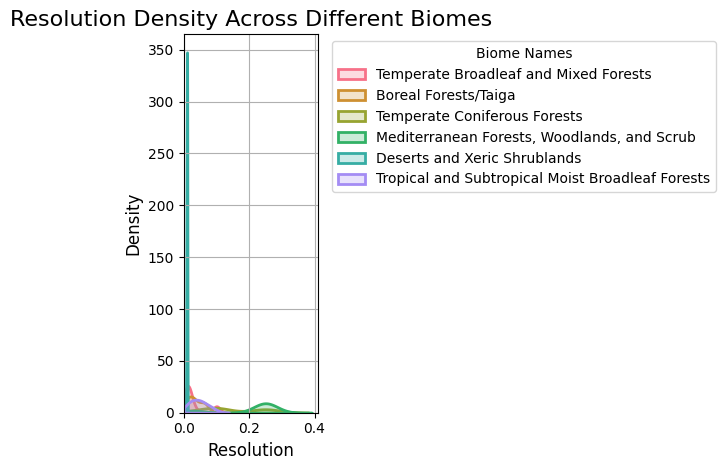

In [16]:
# Use a color palette for better distinction between the different biomes
palette = sns.color_palette("husl", meta_df["biome_name"].nunique())

# Iterate over each biome name and plot the KDE for its resolution
for idx, biome_name in enumerate(meta_df["biome_name"].unique()):
    sns.kdeplot(
        meta_df[meta_df["biome_name"] == biome_name]["resolution"],
        label=biome_name,
        shade=True,
        color=palette[idx],
        linewidth=2,
        clip=(0, None),  # Ensures the KDE starts from 0
    )

# Customize the plot for better readability
plt.title("Resolution Density Across Different Biomes", fontsize=16)
plt.xlabel("Resolution", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Biome Names", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# Adjust x-axis to start at 0
plt.xlim(0, None)

# Show the plot
plt.tight_layout()
plt.show()

In [4]:
df["global_file_path"] = df["file_path"].apply(
    lambda x: x.replace("/net/scratch/jmoehring/", "/")
)

In [7]:
df["ratio"] = df["negatives"] / df["positives"]

In [ ]:
df.head(120)

In [30]:
df["global_file_path"] = df["file_path"].apply(
    lambda x: x.replace("/net/scratch/jmoehring", "")
)

In [6]:
df.to_csv("/net/scratch/jmoehring/tiles_register_512.csv", index=False)

In [7]:
df = pd.read_csv(
    "/net/scratch/jmoehring/checkpoints/10k_1024px_60epochs_3fold_bf1/10k_1024px_60epochs_3fold_bf1.csv"
)

In [8]:
eval_df = df.query("epoch == 60")

In [28]:
df_grouped_2 = df_grouped.groupby("treshold")["f1"].mean().reset_index()

In [ ]:
df_grouped["biome"].value_counts()

In [ ]:
df_grouped_2.head(10)

In [ ]:
df_grouped.head()

In [20]:
# loss function (binary cross entropy)
criterion = nn.BCEWithLogitsLoss()

In [45]:
target = torch.Tensor([[0, 0], [0, 1]])
input = torch.Tensor([[0, 0], [0, 1]])
target = target.unsqueeze(2)
input = input.unsqueeze(2)
# Broadcast the values along the third dimension to make them 2x2x12
target = target.expand(2, 2, 12)
input = input.expand(2, 2, 12)
target = target.permute(2, 0, 1)
input = input.permute(2, 0, 1)

input[6, 0, 0] = 0.5

In [ ]:
criterion(input, target)

In [ ]:
dice_coeff(input, target)

In [31]:
df = pd.read_csv("/net/scratch/jmoehring/tiles_register_1024_biome.csv")

In [ ]:
df.query("biome == 13").head(100)

In [ ]:
df.info()

In [6]:
df2 = pd.read_csv("/net/scratch/jmoehring/tiles_register_biome_bin.csv")

In [ ]:
df2.info()

In [11]:
image_path = "/net/scratch/jmoehring/tiles_1024/quebec_2021-10-07-sbl-cloutier-z2-rgb/0.019/9764_23361_mask.tif"

In [ ]:
image = Image.open(image_path).convert("RGB")

In [107]:
mask_src = rasterio.open(
    "/net/scratch/jmoehring/inference/100k_samples_biome_stratified_treefold_smallval_testset/uavforsat_2017_CFB050_ortho.tif"
)

In [4]:
image_src = rasterio.open("/net/home/jmoehring/standing-deadwood/download.tif")

In [109]:
contours = measure.find_contours(image=mask_src.read(1), level=0.5)

In [ ]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(np.moveaxis(image_src.read(), 0, -1), cmap=plt.cm.gray)


# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="orange")

ax.axis()
ax.set_xlim(0, image_src.width)
ax.set_ylim(image_src.height, 0)

# ax.set_xlim(10500, 14500)
# ax.set_ylim(14500, 10500)

plt.show()

In [ ]:
plt.savefig("contour1.png", dpi=100)

In [ ]:
contours

In [3]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles_register_biome_bin.csv")

In [ ]:
register_df.info()

In [5]:
images_df = register_df.groupby("base_file_name").min("resolution_bin").reset_index()

In [ ]:
register_df[register_df["file_path"].str.contains("13905_8833.tif")]

In [ ]:
register_df["resolution_bin"].hist()

In [ ]:
register_df["resolution_bin_str"].nunique()

In [10]:
# Calculate the value counts
value_counts = register_df["resolution_bin"].value_counts()

# Calculate the square root of the counts
sqrt_counts = value_counts.apply(lambda x: x**0.6)

# get the inverse of the square root
class_weights = 1 / sqrt_counts

In [ ]:
import seaborn as sns

# plot hisogram with value counts multiplied by the class weights
# Set the style and context of seaborn
sns.set_style("whitegrid")
sns.set_context("notebook")

# Plot the histogram
register_df["resolution_bin"].map(class_weights)


# Set the title and labels
plt.title("Histogram of Resolution Bin")
plt.xlabel("Resolution Bin")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [125]:
sample_weights = train_register["resolution_bin"].map(class_weights)

In [ ]:
normalized_counts

In [ ]:
fig = (
    register_df["resolution_bin"]
    .value_counts()
    .plot(kind="bar", xlabel="Resolution [m]", ylabel="Image frequency")
)
import matplotlib.ticker as ticker

ax = plt.gca()  # get the current axes
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:0.0f}k".format(x / 1000))
)

# set bar color to #1B4079 all children
for i, bar in enumerate(fig.patches):
    bar.set_color("#1B4079")

# save the figure
plt.savefig("resolution_bin_histogram.png", dpi=800)

In [ ]:
fig.savefig("resolution_bin_histogram.png")

In [ ]:
rounded_inverse_counts.plot(kind="bar")

In [ ]:
from sklearn.model_selection import StratifiedKFold

base_file_register = (
    register_df.groupby("base_file_name")
    .agg({"resolution_bin": "min", "biome": "first"})
    .reset_index()
)
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# get the train and test file register of the first fold
train_index, test_index = list(
    kfold.split(base_file_register, base_file_register[["biome"]].astype(str))
)[0]
train_files = base_file_register.iloc[train_index]
test_files = base_file_register.iloc[test_index]

train_register = register_df[
    register_df["base_file_name"].isin(train_files["base_file_name"])
]
test_register = register_df[
    register_df["base_file_name"].isin(test_files["base_file_name"])
]

In [ ]:
base_file_register.head()

In [ ]:
train_files["biome"].hist()

In [ ]:
test_files["biome"].hist()

In [12]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
run_id = "garg20i1"
api = wandb.Api()
experiment = api.run(f"jmoehring/standing-deadwood-unet-pro/{run_id}")

In [5]:
fold = 0
epoch = 19

In [6]:
eval_df_1 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{0}_epoch_{19}.csv"
)

In [7]:
eval_df_2 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{1}_epoch_{12}.csv"
)

In [8]:
eval_df_3 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{2}_epoch_{20}.csv"
)

In [28]:
eval_df_4 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_100k_samples_biome_stratified_onefold_val_fold_0_epoch_20.csv"
)

In [9]:
# union of the two dataframes
eval_df = pd.concat([eval_df_1, eval_df_2, eval_df_3])

In [ ]:
# add new column biome names
biome_names = {
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    12: "Mediteranean Forests",
    13: "Deserts and Xeric Shrublands",
}
eval_df["biome_name"] = eval_df["biome"].map(biome_names)

In [18]:
eval_df_t = eval_df[eval_df["treshold"] == 0.8]

In [ ]:
sns.set_theme()
pivoted = eval_df_t.pivot_table(
    index="biome_name", columns="resolution_bin", values="precision"
)
pivoted_labels = eval_df_t.pivot_table(
    index="biome_name",
    columns="resolution_bin",
    values="precision",
    aggfunc="mean",
)
ax = sns.heatmap(
    pivoted,
    cmap="rocket",
    annot=pivoted_labels,
    fmt=".1f",
    cbar_kws={"label": "F1-Score"},
)
# add "k" after the numbers
# for t in ax.texts:
#     t.set_text(t.get_text() + "k")

ax.set_ylabel("")
ax.set_xlabel("Resolution [m]")
fig = ax.get_figure()
fig.set_size_inches(10, 5)
plt.show()

In [14]:
eval_df_b = eval_df[eval_df["biome"] == 12]

In [ ]:
sns.set_theme()
pivoted = eval_df.pivot_table(
    index="treshold", columns="resolution_bin", values="f1", aggfunc="mean"
)
ax = sns.heatmap(
    pivoted,
    cmap="rocket",
    annot=True,
    fmt=".3f",
    cbar_kws={"label": "F1-Score"},
)

ax.set_ylabel("")
ax.set_xlabel("Resolution [m]")
fig = ax.get_figure()
fig.set_size_inches(10, 5)
plt.show()

In [57]:
fig.savefig("f1_score_heatmap.png", dpi=800, bbox_inches="tight")

In [ ]:
eval_df["biome"].value_counts()

In [26]:
images_df = register_df.groupby("base_file_name").min("resolution_bin").reset_index()